1. Load required packages

In [1]:
import warnings
import calmap
import joblib
import random
import time
import os
from plotly_calplot import calplot
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from yellowbrick.features import Rank2D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ClassificationReport
from sklearn.model_selection import train_test_split
from yellowbrick.target import ClassBalance
from yellowbrick.target import class_balance
from sklearn import tree
from xgboost import XGBClassifier,plot_importance
from IPython.display import Image

warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


Machine Learning Process

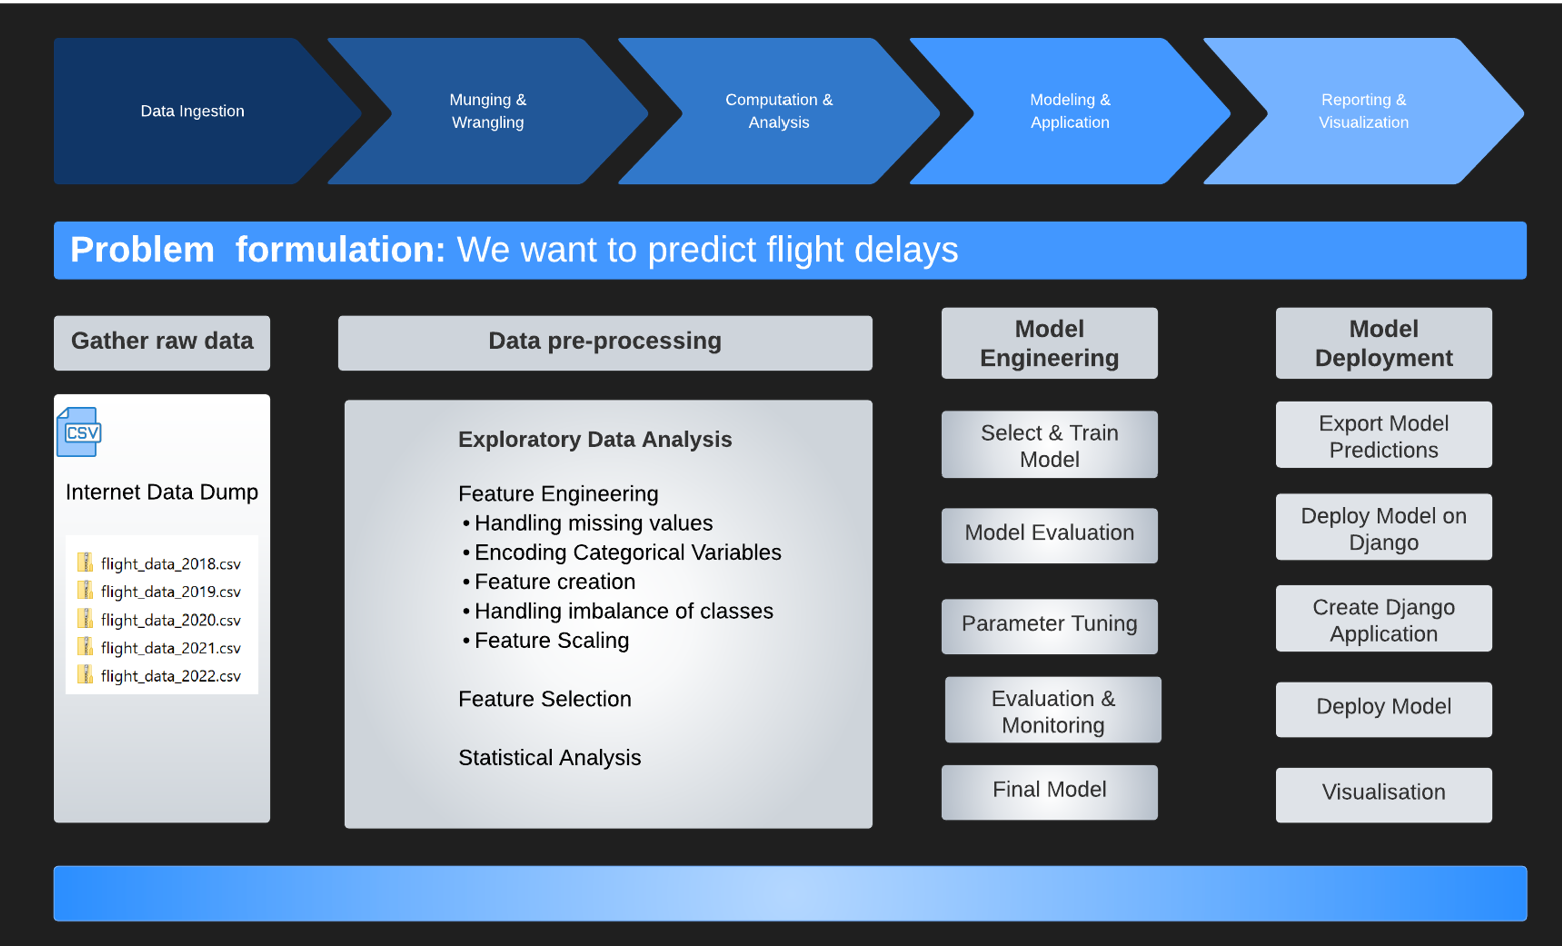

In [3]:
Image("../../data/images/MLProcess.png")

### Load in the data

In [4]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182019_20212022/all_flight_data_20182022NC.zip",skiprows=skip, low_memory=False, encoding="iso-8859-1")

In [5]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [6]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [7]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [8]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



In [9]:
df_flights.head()

,Unnamed: 0,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Originally_Scheduled_Code_Share_Airline,DOT_ID_Originally_Scheduled_Code_Share_Airline,IATA_Code_Originally_Scheduled_Code_Share_Airline,Flight_Num_Originally_Scheduled_Code_Share_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,69,2018,1,1,1,1,2018-01-01,DL,DL_CODESHARE,19790,DL,3300,NaN,NaN,NaN,NaN,9E,20363,9E,N132EV,3300,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,13795,1379502,33795,OAJ,"Jacksonville/Camp Lejeune, NC",NC,37,North Carolina,36,2215,2214.0,-1.0,0.0,0.0,-1.0,2200-2259,18.0,2232.0,2327.0,3.0,2340,2330.0,-10.0,0.0,0.0,-1.0,2300-2359,0.0,NaN,0.0,85.0,76.0,55.0,1.0,399.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,128,2018,1,1,4,4,2018-01-04,DL,DL_CODESHARE,19790,DL,3301,NaN,NaN,NaN,NaN,9E,20363,9E,N836AY,3301,11617,1161708,31617,EWN,"New Bern/Morehead/Beaufort, NC",NC,37,North Carolina,36,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1415,NaN,NaN,NaN,NaN,NaN,1400-1459,NaN,NaN,NaN,NaN,1605,NaN,NaN,NaN,NaN,NaN,1600-1659,1.0,C,0.0,110.0,NaN,NaN,1.0,433.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,140,2018,1,1,19,5,2018-01-19,DL,DL_CODESHARE,19790,DL,3301,NaN,NaN,NaN,NaN,9E,20363,9E,N8869B,3301,11617,1161708,31617,EWN,"New Bern/Morehead/Beaufort, NC",NC,37,North Carolina,36,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1415,1416.0,1.0,1.0,0.0,0.0,1400-1459,9.0,1425.0,1538.0,11.0,1605,1549.0,-16.0,0.0,0.0,-2.0,1600-1659,0.0,NaN,0.0,110.0,93.0,73.0,1.0,433.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,186,2018,1,1,7,7,2018-01-07,DL,DL_CODESHARE,19790,DL,3302,NaN,NaN,NaN,NaN,9E,20363,9E,N8936A,3302,11641,1164102,31641,FAY,"Fayetteville, NC",NC,37,North Carolina,36,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1853,1842.0,-11.0,0.0,0.0,-1.0,1800-1859,15.0,1857.0,2002.0,12.0,2030,2014.0,-16.0,0.0,0.0,-2.0,2000-2059,0.0,NaN,0.0,97.0,92.0,65.0,1.0,331.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
  - Feature creation
  - Handling of imbalanced classes in dataset
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [10]:
df_flights.dtypes

Unnamed: 0                                   int64
Year                                         int64
Quarter                                      int64
Month                                        int64
DayofMonth                                   int64
DayOfWeek                                    int64
FlightDate                                  object
Marketing_Airline_Network                   object
Operated_or_Branded_Code_Share_Partners     object
DOT_ID_Marketing_Airline                     int64
                                            ...   
Div5Airport                                float64
Div5AirportID                              float64
Div5AirportSeqID                           float64
Div5WheelsOn                               float64
Div5TotalGTime                             float64
Div5LongestGTime                           float64
Div5WheelsOff                              float64
Div5TailNum                                float64
Duplicate                      

In [11]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

##########Flight Status Categories####################
###############DepDelayGroups#########################
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 0.5, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 0.5), "DepDelayClass"] = "Delayed"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Delayed"
    return df_flights

def tweak_df_flights(df_flights):
    DepDelay_Class(df_flights)
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime","DepDelayClass"
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "int16",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16",
            "DepDelayClass": "category"
        }
    )


df_flights = tweak_df_flights(df_flights)

print(df_flights.shape)
df_flights.tail()


(619641, 44)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude
619636,2022-08-26,Comair Inc.,N548NN,5293,11057,CLT,"Charlotte, NC",NC,North Carolina,12217,HSV,"Huntsville, AL",AL,Alabama,1813,1809.0,-4.0,0.0,0.0,1800-1859,54.0,1901.0,5.0,1843,1906.0,23.0,1.0,1800-1859,0,none,False,90.0,58.0,333.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,OnTime,35.21875,-80.9375
619637,2022-08-08,Comair Inc.,N508AE,5293,12217,HSV,"Huntsville, AL",AL,Alabama,11057,CLT,"Charlotte, NC",NC,North Carolina,1917,1929.0,12.0,0.0,12.0,1900-1959,17.0,2140.0,9.0,2150,2148.0,0.0,0.0,2100-2159,0,none,False,93.0,54.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,34.62500,-86.7500
619638,2022-08-14,Comair Inc.,N579NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,837,837.0,0.0,0.0,0.0,0800-0859,12.0,946.0,6.0,958,952.0,0.0,0.0,0900-0959,0,none,False,81.0,57.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625
619639,2022-08-22,Comair Inc.,N602NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,924.0,50.0,1.0,50.0,0800-0859,17.0,1038.0,2.0,1006,1040.0,34.0,1.0,1000-1059,0,none,False,92.0,57.0,319.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,38.84375,-77.0625
619640,2022-08-31,Comair Inc.,N595NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,829.0,-5.0,0.0,0.0,0800-0859,24.0,946.0,2.0,1006,948.0,0.0,0.0,1000-1059,0,none,False,92.0,53.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625


In [12]:
#df_flights.describe()

In [13]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619641 entries, 0 to 619640
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   FlightDate         619641 non-null  datetime64[ns]
 1   Operating_Airline  619641 non-null  category      
 2   Tail_Number        619641 non-null  category      
 3   Flight_Number      619641 non-null  int16         
 4   OriginAirportID    619641 non-null  int16         
 5   Origin             619641 non-null  category      
 6   OriginCityName     619641 non-null  category      
 7   OriginState        619641 non-null  category      
 8   OriginStateName    619641 non-null  category      
 9   DestAirportID      619641 non-null  int16         
 10  Dest               619641 non-null  category      
 11  DestCityName       619641 non-null  category      
 12  DestState          619641 non-null  category      
 13  DestStateName      619641 non-null  category

In [14]:

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '0',
    'Delayed': '1'
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)

df_flights["DepDelayClass_ordinal"] = df_flights["DepDelayClass_ordinal"].astype("float16")


print(df_flights.shape)
df_flights.tail(3)

(619641, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
619638,2022-08-14,Comair Inc.,N579NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,837,837.0,0.0,0.0,0.0,0800-0859,12.0,946.0,6.0,958,952.0,0.0,0.0,0900-0959,0,none,False,81.0,57.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625,0.0
619639,2022-08-22,Comair Inc.,N602NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,924.0,50.0,1.0,50.0,0800-0859,17.0,1038.0,2.0,1006,1040.0,34.0,1.0,1000-1059,0,none,False,92.0,57.0,319.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,38.84375,-77.0625,1.0
619640,2022-08-31,Comair Inc.,N595NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,834,829.0,-5.0,0.0,0.0,0800-0859,24.0,946.0,2.0,1006,948.0,0.0,0.0,1000-1059,0,none,False,92.0,53.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,38.84375,-77.0625,0.0


In [15]:

df_flights.loc[df_flights['Cancelled'] == 0].head()


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
0,2018-01-01,Endeavor Air Inc.,N132EV,3300,10397,ATL,"Atlanta, GA",GA,Georgia,13795,OAJ,"Jacksonville/Camp Lejeune, NC",NC,North Carolina,2215,2214.0,-1.0,0.0,0.0,2200-2259,18.0,2328.0,3.0,2340,2330.0,0.0,0.0,2300-2359,0,none,False,85.0,55.0,399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.62500,-84.4375,0.0
2,2018-01-19,Endeavor Air Inc.,N8869B,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1416.0,1.0,0.0,1.0,1400-1459,9.0,1538.0,11.0,1605,1549.0,0.0,0.0,1600-1659,0,none,False,110.0,73.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,35.06250,-77.0625,1.0
3,2018-01-07,Endeavor Air Inc.,N8936A,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1842.0,-11.0,0.0,0.0,1800-1859,15.0,2002.0,12.0,2030,2014.0,0.0,0.0,2000-2059,0,none,False,97.0,65.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.00000,-78.8750,0.0
4,2018-01-10,Endeavor Air Inc.,N8888D,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1850.0,-3.0,0.0,0.0,1800-1859,21.0,2012.0,13.0,2030,2025.0,0.0,0.0,2000-2059,0,none,False,97.0,61.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.00000,-78.8750,0.0
5,2018-01-14,Endeavor Air Inc.,N800AY,3303,11433,DTW,"Detroit, MI",MI,Michigan,15412,TYS,"Knoxville, TN",TN,Tennessee,1230,1339.0,69.0,1.0,69.0,1200-1259,19.0,1506.0,3.0,1414,1509.0,55.0,1.0,1400-1459,0,none,False,104.0,68.0,443.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,42.21875,-83.3750,1.0


In [16]:
df_flights.loc[df_flights['Cancelled'] == 1].head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
1,2018-01-04,Endeavor Air Inc.,N836AY,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,0.0,0.0,0.0,0.0,1400-1459,0.0,0.0,0.0,1605,0.0,0.0,0.0,1600-1659,1,National Air System,False,110.0,0.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,35.062500,-77.0625,1.0
23,2018-01-22,Endeavor Air Inc.,N920XJ,3326,12339,IND,"Indianapolis, IN",IN,Indiana,13487,MSP,"Minneapolis, MN",MN,Minnesota,703,0.0,0.0,0.0,0.0,0700-0759,0.0,0.0,0.0,805,0.0,0.0,0.0,0800-0859,1,National Air System,False,122.0,0.0,503.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,39.718750,-86.3125,1.0
38,2018-01-03,Endeavor Air Inc.,N8970D,3338,10731,BQK,"Brunswick, GA",GA,Georgia,10397,ATL,"Atlanta, GA",GA,Georgia,615,0.0,0.0,0.0,0.0,0600-0659,0.0,0.0,0.0,730,0.0,0.0,0.0,0700-0759,1,Weather,False,75.0,0.0,238.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,31.265625,-81.4375,1.0
42,2018-01-17,Endeavor Air Inc.,N8688C,3339,10397,ATL,"Atlanta, GA",GA,Georgia,11778,FSM,"Fort Smith, AR",AR,Arkansas,2143,0.0,0.0,0.0,0.0,2100-2159,0.0,0.0,0.0,2245,0.0,0.0,0.0,2200-2259,1,National Air System,False,122.0,0.0,579.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,33.625000,-84.4375,1.0
62,2018-01-04,Endeavor Air Inc.,N919XJ,3355,12953,LGA,"New York, NY",NY,New York,14492,RDU,"Raleigh/Durham, NC",NC,North Carolina,630,0.0,0.0,0.0,0.0,0600-0659,0.0,0.0,0.0,823,0.0,0.0,0.0,0800-0859,1,National Air System,False,113.0,0.0,431.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,40.781250,-73.8750,1.0


Imbalance of classes 
- Class imbalance will be maintained during evaluation because delays and cancellations are actually as rare as the frequency implies
- Stratified sampling will be used to create train and test splits. This ensures that the test data has roughly the same proportion of classes as the training data.

In [17]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,DepDelayClass,latitude,longitude,DepDelayClass_ordinal
0,2018-01-01,Endeavor Air Inc.,N132EV,3300,10397,ATL,"Atlanta, GA",GA,Georgia,13795,OAJ,"Jacksonville/Camp Lejeune, NC",NC,North Carolina,2215,2214.0,-1.0,0.0,0.0,2200-2259,18.0,2328.0,3.0,2340,2330.0,0.0,0.0,2300-2359,0,none,False,85.0,55.0,399.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,33.6250,-84.4375,0.0
1,2018-01-04,Endeavor Air Inc.,N836AY,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,0.0,0.0,0.0,0.0,1400-1459,0.0,0.0,0.0,1605,0.0,0.0,0.0,1600-1659,1,National Air System,False,110.0,0.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,35.0625,-77.0625,1.0
2,2018-01-19,Endeavor Air Inc.,N8869B,3301,11617,EWN,"New Bern/Morehead/Beaufort, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1415,1416.0,1.0,0.0,1.0,1400-1459,9.0,1538.0,11.0,1605,1549.0,0.0,0.0,1600-1659,0,none,False,110.0,73.0,433.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delayed,35.0625,-77.0625,1.0
3,2018-01-07,Endeavor Air Inc.,N8936A,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1842.0,-11.0,0.0,0.0,1800-1859,15.0,2002.0,12.0,2030,2014.0,0.0,0.0,2000-2059,0,none,False,97.0,65.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.0000,-78.8750,0.0
4,2018-01-10,Endeavor Air Inc.,N8888D,3302,11641,FAY,"Fayetteville, NC",NC,North Carolina,10397,ATL,"Atlanta, GA",GA,Georgia,1853,1850.0,-3.0,0.0,0.0,1800-1859,21.0,2012.0,13.0,2030,2025.0,0.0,0.0,2000-2059,0,none,False,97.0,61.0,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OnTime,35.0000,-78.8750,0.0


In [18]:
y = df_flights["DepDelayClass"]
#class_balance(y)
y.value_counts()

OnTime     394479
Delayed    225137
Name: DepDelayClass, dtype: int64

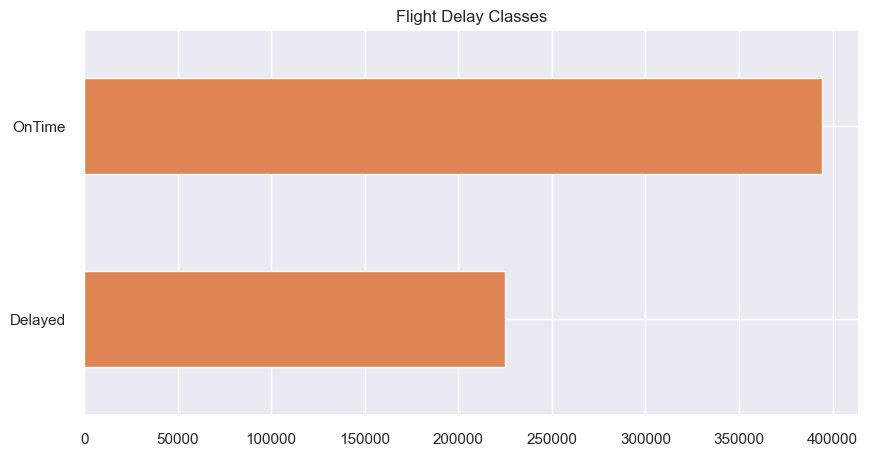

In [19]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

In [20]:
# Is class balanced or imbalanced?
df_flights["DepDelayClass"].value_counts()

OnTime     394479
Delayed    225137
Name: DepDelayClass, dtype: int64

In [21]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619641 entries, 0 to 619640
Data columns (total 45 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FlightDate             619641 non-null  datetime64[ns]
 1   Operating_Airline      619641 non-null  category      
 2   Tail_Number            619641 non-null  category      
 3   Flight_Number          619641 non-null  int16         
 4   OriginAirportID        619641 non-null  int16         
 5   Origin                 619641 non-null  category      
 6   OriginCityName         619641 non-null  category      
 7   OriginState            619641 non-null  category      
 8   OriginStateName        619641 non-null  category      
 9   DestAirportID          619641 non-null  int16         
 10  Dest                   619641 non-null  category      
 11  DestCityName           619641 non-null  category      
 12  DestState              619641 non-null  cate

In [22]:
####Feature Selection#####
ml_cols = [
    #'FlightDate',
    #'Operating_Airline',
    #'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    #'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    #'Cancelled',
    #'CancellationCode',
    #'Diverted',
    #'CRSElapsedTime',
    'AirTime',
    #'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    #'latitude',
    #'longitude',
    #'DepDelayClass',
    'DepDelayClass_ordinal'
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2 = df_flights_2[df_flights_2["DepDelayClass_ordinal"].notna()]
df_flights_2.columns

Index(['Flight_Number', 'OriginAirportID', 'DestAirportID', 'CRSDepTime',
       'DepTime', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'AirTime',
       'TotalAddGTime', 'DepDelayClass_ordinal'],
      dtype='object')

In [23]:
df_flights_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619616 entries, 0 to 619640
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Flight_Number          619616 non-null  int16  
 1   OriginAirportID        619616 non-null  int16  
 2   DestAirportID          619616 non-null  int16  
 3   CRSDepTime             619616 non-null  int16  
 4   DepTime                619616 non-null  float16
 5   TaxiOut                619616 non-null  float16
 6   WheelsOn               619616 non-null  float16
 7   TaxiIn                 619616 non-null  float16
 8   CRSArrTime             619616 non-null  int16  
 9   AirTime                619616 non-null  float16
 10  TotalAddGTime          619616 non-null  float16
 11  DepDelayClass_ordinal  619616 non-null  float16
dtypes: float16(7), int16(5)
memory usage: 18.9 MB


### Model Building
- Model Selection
- Hyperparameter tuning
- Cross validation
- Model Evaluation

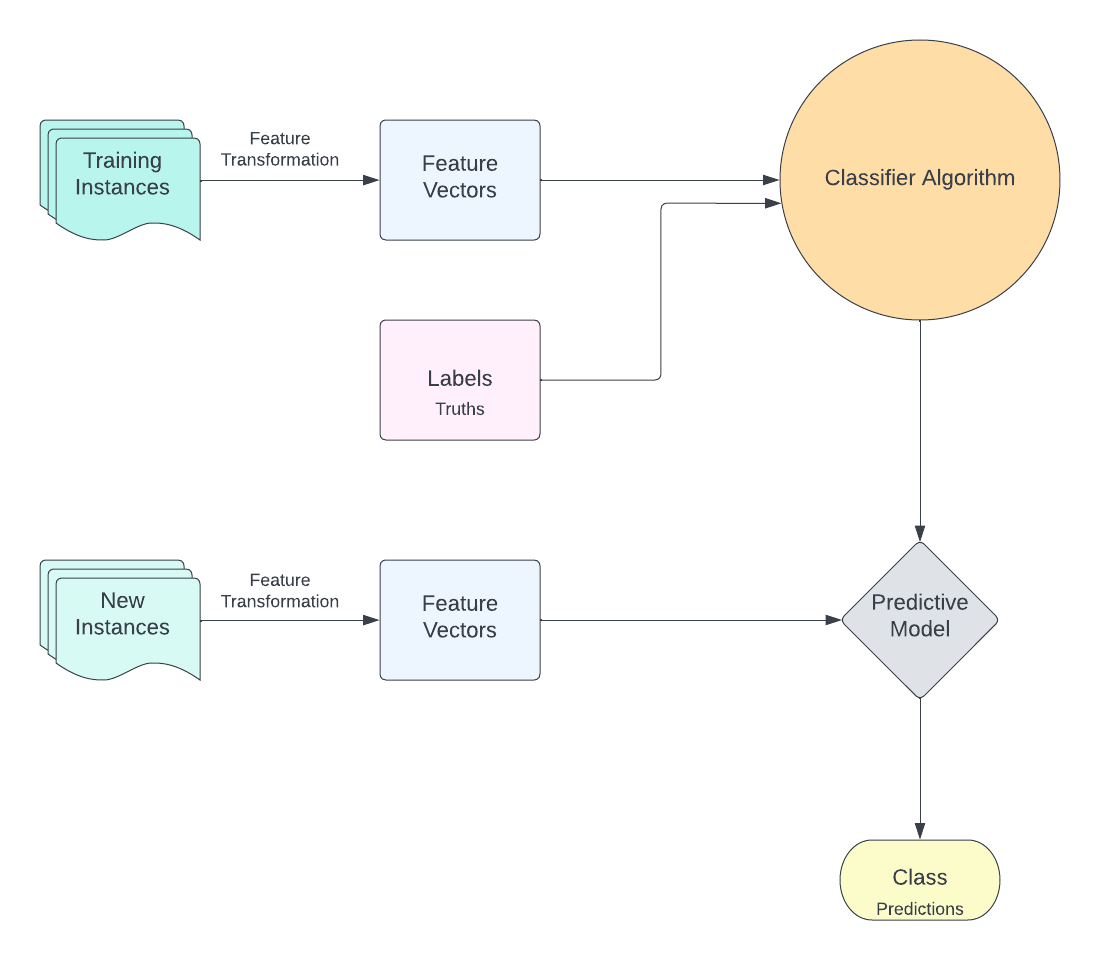

In [24]:
Image("../../data/images/ModellingWorkflow.png")

Extract independent & dependent variables

In [25]:
#df_flights_2.columns.to_list()

In [26]:
X = df_flights_2[['Flight_Number',
                  'OriginAirportID',
                  'DestAirportID',
                  'CRSDepTime',
                  'DepTime',
                  'TaxiOut',
                  'WheelsOn',
                  'TaxiIn',
                  'CRSArrTime',
                  'AirTime',
                  'TotalAddGTime']] # independent features
y = df_flights_2['DepDelayClass_ordinal'] # dependent feature

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X shape: (619616, 11)
y shape: (619616,)


In [27]:
# Check to see if dataset is imbalanced
y.value_counts(dropna=False)

0.0    394479
1.0    225137
Name: DepDelayClass_ordinal, dtype: int64

In [28]:
df_flights_2.dtypes

Flight_Number              int16
OriginAirportID            int16
DestAirportID              int16
CRSDepTime                 int16
DepTime                  float16
TaxiOut                  float16
WheelsOn                 float16
TaxiIn                   float16
CRSArrTime                 int16
AirTime                  float16
TotalAddGTime            float16
DepDelayClass_ordinal    float16
dtype: object

In [29]:
df_flights_2.shape

(619616, 12)

In [30]:
df_flights_2.describe()

,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,AirTime,TotalAddGTime,DepDelayClass_ordinal
count,619616.000000,619616.000000,619616.000000,619616.000000,619616.0,619616.0,619616.0,619616.0,619616.000000,619616.0,619616.0,619616.0
mean,2687.678682,12679.527669,12674.369053,1328.210889,NaN,NaN,NaN,NaN,1487.409673,NaN,NaN,NaN
std,1838.272781,1522.760120,1522.801010,486.485404,NaN,0.0,NaN,0.0,512.800656,NaN,0.0,0.0
min,1.000000,10135.000000,10135.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
25%,1102.000000,11292.000000,11292.000000,915.000000,900.0,11.0,1030.0,4.0,1104.000000,57.0,0.0,0.0
50%,2290.000000,12889.000000,12889.000000,1320.000000,1314.0,14.0,1448.0,6.0,1515.000000,90.0,0.0,0.0
75%,4237.000000,14057.000000,14057.000000,1730.000000,1736.0,19.0,1902.0,9.0,1917.000000,138.0,0.0,1.0
max,9663.000000,16869.000000,16869.000000,2359.000000,2400.0,184.0,2400.0,218.0,2400.000000,683.0,223.0,1.0


Fit & Evaluate the model 


In [31]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    #kf = KFold(n_splits = 12, shuffle=True)
    ##### StratifiedKFold used to overcome the problem of imbalanced dataset
    skf = StratifiedKFold(n_splits = 12, shuffle=True)
    
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    joblib.dump(estimator, outpath)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))


Decision Tree Classification
- Decision Trees are a supervised learning method used for classification and regression

In [32]:
fit_and_evaluate(X, y, DecisionTreeClassifier, "Flight Decision Tree Classifier")

Build and Validation of Flight Decision Tree Classifier took 51.251 seconds
Validation scores are as follows:

precision    0.878793
recall       0.878688
accuracy     0.878688
f1           0.878736
dtype: float64

Fitted model written to:
d:\Georgetown\georgetown_analytics\team-3\flight_model\notebooks\ML_MODELLING\flight-decision-tree-classifier.pickle


Random Forest Classification


In [33]:
fit_and_evaluate(X, y, RandomForestClassifier, "Flight Random Forest Classifier")


Build and Validation of Flight Random Forest Classifier took 1250.051 seconds
Validation scores are as follows:

precision    0.940562
recall       0.937705
accuracy     0.937705
f1           0.936620
dtype: float64

Fitted model written to:
d:\Georgetown\georgetown_analytics\team-3\flight_model\notebooks\ML_MODELLING\flight-random-forest-classifier.pickle


XGBoost Classification

In [34]:
fit_and_evaluate(X, y, XGBClassifier, "Flight XGBoost Classifier")

Build and Validation of Flight XGBoost Classifier took 142.699 seconds
Validation scores are as follows:

precision    0.982237
recall       0.981889
accuracy     0.981889
f1           0.981799
dtype: float64

Fitted model written to:
d:\Georgetown\georgetown_analytics\team-3\flight_model\notebooks\ML_MODELLING\flight-xgboost-classifier.pickle


### AdaBoost

Adaptive Boosting (AdaBoost) is an ensemble method that sums the predictions made by multiple decision trees. Additional models are added and trained on instances that were incorrectly predicted (boosting).

In [35]:
fit_and_evaluate(X, y, AdaBoostClassifier, "Flight AdaBoost Classifier")

Build and Validation of Flight AdaBoost Classifier took 235.009 seconds
Validation scores are as follows:

precision    0.746297
recall       0.713059
accuracy     0.713059
f1           0.662114
dtype: float64

Fitted model written to:
d:\Georgetown\georgetown_analytics\team-3\flight_model\notebooks\ML_MODELLING\flight-adaboost-classifier.pickle
